# FSLD
### Fast community detection algorithm using a local and multi-level diffusion method in social networks

## Steps: 
### 1. Label diffusion step
### 2. Label updating step
### 3. Label diffusion to degree 1 nodes
### 4. Merge step

In [ ]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import collections
from collections import defaultdict

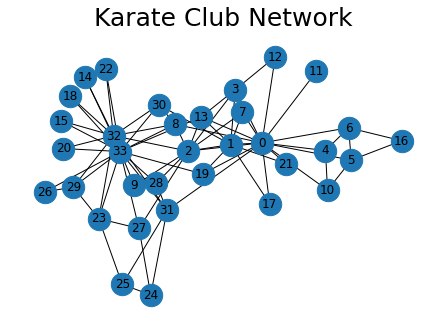

In [ ]:
# Fetching karate club graph from networkx library
# TODO: Fetch this karate club graph from downloaded CSV file
G = nx.karate_club_graph()

nx.draw(G, with_labels=True, node_size=500)
plt.title("Karate Club Network", fontsize=25)
plt.show()

## Step 1: Label assigning and diffusion for nodes with degree 2 and higher

In [ ]:
# Grouping of nodes according degrees
group_of_degrees = {}

for v in G:
    degree_of_v = G.degree(v)
    
    if degree_of_v not in group_of_degrees.keys():
        group_of_degrees[degree_of_v] = [v]
    else:
        group_of_degrees[degree_of_v].append(v)

print(group_of_degrees)

{16: [0], 9: [1], 10: [2], 6: [3, 31], 3: [4, 10, 19, 24, 25, 28], 4: [5, 6, 7, 27, 29, 30], 5: [8, 13, 23], 2: [9, 12, 14, 15, 16, 17, 18, 20, 21, 22, 26], 1: [11], 12: [32], 17: [33]}


In [ ]:
# Assigning label=0 to every node
zero_label_dict = {}
for v in G:
    zero_label_dict[v] = 0

nx.set_node_attributes(G, zero_label_dict, "label")

In [ ]:
# Helper Functions
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def get_label_of_node(node):
  return G.nodes[node]["label"]


def set_label_of_node(node, label):
  G.nodes[node]["label"] = label


def dcn(v, i):
    degree_v = G.degree(v)
    Nv = list(G.neighbors(v))
    Ni = list(G.neighbors(i))
    
    intersection_Nv_Ni = intersection(Nv, Ni)
    
    dcn_v_i = degree_v + 2*len(intersection_Nv_Ni)
    return dcn_v_i
  

def max_similarity_node_among_neighbors(target_node, target_node_neighbors):
    max_dcn = -1
    max_dcn_deg = -1
    # Here -1 value represents that, the node with maximum influence 
    # has not been found yet
    max_influence_neighbor_node = -1

    for neighbor in target_node_neighbors:
        dcn_v_i = dcn(target_node, neighbor)
        # -> If DCN of any 2 nodes are same, then we need to choose neighbour
        # -> w/ higher degree
        if max_dcn < dcn_v_i:
            max_dcn = dcn_v_i
            max_dcn_deg = G.degree(neighbor)
            max_influence_neighbor_node = neighbor
        elif max_dcn == dcn_v_i and max_dcn_deg < G.degree(neighbor):
            max_dcn_deg = G.degree(neighbor)
            max_influence_neighbor_node = neighbor


    return (max_influence_neighbor_node, max_dcn)


def diffuse_node_label(node, counter):
    node_neighbors = list(G.neighbors(node))
    
    # Check for Case 1: None of the neighbors are diffused
    all_neighbors_label_zero_flag = True
    for neighbor in node_neighbors:
      if get_label_of_node(neighbor):
        all_neighbors_label_zero_flag = False
        break;
    
    if all_neighbors_label_zero_flag:
      max_influence_neighbor_node, _ = max_similarity_node_among_neighbors(node, node_neighbors)
      # We need to change the label of node and max_influence_node to new label
      counter+=1
      set_label_of_node(max_influence_neighbor_node, counter)
      set_label_of_node(node, counter)
      
      return counter
    
    # Check for Case 2 and 3: If any of the neighbors is 0 or not
    any_neighbor_label_zero_flag = False
    single_node_for_each_label_flag = True
    label_freq_dict = defaultdict(list)
    for neighbor in node_neighbors:
      neighbor_label = get_label_of_node(neighbor)
      if len(label_freq_dict[neighbor]) > 0:
        single_node_for_each_label_flag = False
      label_freq_dict[neighbor_label].append(neighbor)
    for label, neighbor_nodes in label_freq_dict.items():
      sorted_neighbor_nodes = sorted(neighbor_nodes, key = lambda x: G.degree(x))
      label_freq_dict[label] = sorted_neighbor_nodes
    if len(label_freq_dict[0]) > 0:
      any_neighbor_label_zero_flag = True

    # Case 2
    if any_neighbor_label_zero_flag == False:
      if single_node_for_each_label_flag:
        max_influence_neighbor_node, _ = max_similarity_node_among_neighbors(node, node_neighbors)
        set_label_of_node(node, get_label_of_node(max_influence_neighbor_node))
      else:
        neighbors_with_highest_deg_for_each_label = []
        for label, neighbor_nodes in label_freq_dict.items():
          if len(neighbor_nodes) == 0:
            continue
          highest_deg_node = neighbor_nodes[len(neighbor_nodes) - 1]
          neighbors_with_highest_deg_for_each_label.append(highest_deg_node)
        
        max_influence_neighbor_node, _ = max_similarity_node_among_neighbors(node, neighbors_with_highest_deg_for_each_label)
        set_label_of_node(node, get_label_of_node(max_influence_neighbor_node))
      return counter    



    # Case 3
    else:
      # get the higest freq labels and all its nodes
      _highest_label_freq = -1
      label_list = []
      for label, neighbor_nodes in label_freq_dict.items():
        if len(neighbor_nodes) > _highest_label_freq:
          label_list = [label] 
          _highest_label_freq = len(neighbor_nodes)
        elif len(neighbor_nodes) == _highest_label_freq:
          label_list.append(label)
      
      highest_deg_nodes_with_major_label = []
      for label in label_list:
        highest_deg_nodes_with_major_label.append(label_freq_dict[label][len(label_freq_dict[label])-1])
      
      highest_deg_nodes_with_major_label = sorted(highest_deg_nodes_with_major_label, key = lambda x: G.degree(x) )

      to_be_infused_node = highest_deg_nodes_with_major_label[len(highest_deg_nodes_with_major_label) -1 ]

      if get_label_of_node(to_be_infused_node) == 0:
        node_neighbors = list(G.neighbors(node))
        node_neighbors = sorted(node_neighbors, key = lambda x: G.degree(x) )
        node_neighbors.reverse()
        highest_deg_node_with_0_label = -1
        highest_deg_node_with_non_0_label = -1
        for n in node_neighbors:
          if highest_deg_node_with_0_label == -1 and get_label_of_node(n) == 0:
            highest_deg_node_with_0_label = n
          if highest_deg_node_with_non_0_label == -1 and get_label_of_node(n) == 0:
            highest_deg_node_with_non_0_label = n
          if highest_deg_node_with_non_0_label != -1 and highest_deg_node_with_0_label != -1:
            break

        if(dcn(node, highest_deg_node_with_non_0_label) > dcn(node, highest_deg_node_with_0_label)):
          set_label_of_node(node, get_label_of_node(highest_deg_node_with_non_0_label))
        else:
          counter+=1
          set_label_of_node(highest_deg_node_with_0_label, counter)
          set_label_of_node(node, counter)
        
      else: 
        set_label_of_node(node, get_label_of_node(to_be_infused_node))

      return counter    

In [ ]:
# Counter represents the label for next node
counter = 0
highest_degree = -1

for v in G:
  if G.degree(v) > highest_degree:
    highest_degree = G.degree(v)

for current_degree_level in range(2, highest_degree+1):
  if current_degree_level not in group_of_degrees:
    continue

  # Select target node
  current_degree_nodes = group_of_degrees[current_degree_level]

  for target_node in current_degree_nodes:
      # We need to only process a target_node if its label is 0 (not diffused)
      if get_label_of_node(target_node) == 0:
          counter = diffuse_node_label(target_node, counter)



## Step 2: Label updating of degree 2 and higher nodes

In [ ]:
# Helper functions for step 2
def update_node_label(target_node):
  neighbor_nodes = list(G.neighbors(target_node))
  neighbor_node_with_max_influence, _ = max_similarity_node_among_neighbors(target_node, neighbor_nodes)

  if get_label_of_node(target_node) != get_label_of_node(neighbor_node_with_max_influence):
    set_label_of_node(target_node, get_label_of_node(neighbor_node_with_max_influence))


In [ ]:
# Loop over all the degrees from highest to lowest till deg. 2 nodes
for current_degree_level in range(highest_degree, 1, -1):
  if current_degree_level not in group_of_degrees:
    continue

  # Select target node
  current_degree_nodes = group_of_degrees[current_degree_level]

  for target_node in current_degree_nodes:
      update_node_label(target_node)

## Step 3: Label diffusion to degree 1 nodes

In [ ]:
# As degree 1 nodes will be only connected to 1 direct neighbor
# It will be assigned the label of the neighbor

degree_1_nodes = group_of_degrees.get(1, [])

for node in degree_1_nodes:
  set_label_of_node(node, get_label_of_node(list(G.neighbors(node))[0]))
